In [8]:
# Following: http://nessy.info/?p=1202

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

from collections import namedtuple

In [9]:
class Point2(namedtuple("Point2", "x y")):
    pass

class _slicetool(object):
    def __getitem__(self, sl):
        return sl

from enum import Enum

class _slicing(_slicetool, Enum):
    slicetool = 0

slicetool = _slicing.slicetool

def show_image(img):
    opt = {}
    if len(img.shape) < 3:
        opt.update(cmap="gray")
    plt.imshow(img, **opt)
    plt.show()

In [10]:
image_dir = "../data/set_data/my_cards/test"
image_files = sorted(fn for fn in os.listdir(image_dir) if fn.endswith(".jpg"))
image_files = [os.path.join(image_dir, fn) for fn in image_files]

instances = [
    (image_files[0], slicetool[600:1500, 0:850]),
    (image_files[10], slicetool[1100:2000, 250:750]),
]

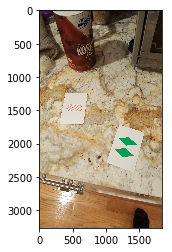

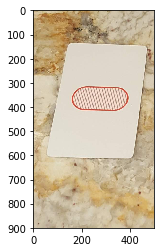

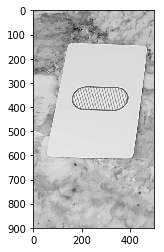

(900, 500)

In [11]:
img_fn, card_slice = instances[1]
img = cv2.imread(img_fn)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

card1 = img[card_slice]
card1_ = cv2.cvtColor(card1, cv2.COLOR_RGB2GRAY)

show_image(img)
show_image(card1)
show_image(card1_)
card1_.shape

In [12]:
bins=256

def show_hist(img):
    plt.hist(img.flatten(), bins=bins, density=True)
# Own version

def get_pdf(img):
    """Count up the pixels by intensity."""
    result = np.zeros(256, dtype=int)
    for val in img.flatten():
        result[val] += 1
    return result


def get_cdf(img):
    """Apply cumulative sum (and normalize) to obtain a cdf."""
    pdf = get_pdf(img)
    temp = np.cumsum(pdf)
    return temp / temp[-1]


def get_transform(img):
    cdf = get_cdf(img)
    # It looks like the cv2 version uses round, not floor or ceil.
    lookup = np.round(cdf * 255).astype(int)
    return np.vectorize(lambda pixel: lookup[pixel])


def my_equalize(img):
    return get_transform(img)(img).astype(np.uint8)

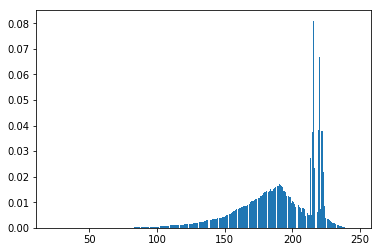

In [13]:
show_hist(card1_)
plt.show()

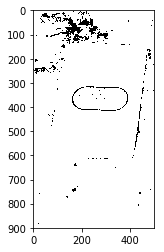

In [14]:
_, card1_thresh = cv2.threshold(card1_, 130, 255, cv2.THRESH_BINARY)
show_image(card1_thresh)

In [15]:
_, contours, _ = cv2.findContours(card1_thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours

sorted_contours = sorted([
    (cv2.contourArea(c), c) for c in contours
], key=lambda a: a[0], reverse=True)

for _, c in sorted_contours:
    cv2.drawContours(card1, [c], -1, (0, 255, 0), 2)

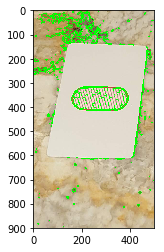

In [16]:
show_image(card1)

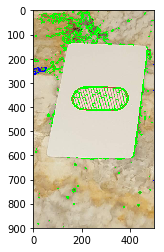

In [17]:
_, card_contour = sorted_contours[0]
cv2.drawContours(card1, [card_contour], -1, (0, 0, 255), 2)
show_image(card1)

In [18]:
rect = cv2.minAreaRect(card_contour)
box = np.int0(cv2.boxPoints(rect))

In [19]:
box

array([[498, 899],
       [  0, 899],
       [  0,   0],
       [498,   0]])

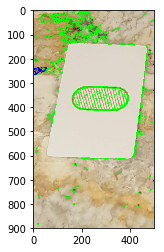

In [20]:
from geom_cv2 import four_point_transform

card1_t = four_point_transform(card1, box)
show_image(card1_t)

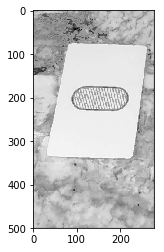

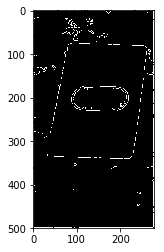

In [21]:
# Some good Python code to steal from: https://github.com/jrosebr1/imutils
# for example:
def resize(image, width=None, height=None, inter=cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation=inter)

    # return the resized image
    return resized

def find_edges(image):
    # convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return find_edges_gray(gray)


def find_edges_gray(image):
    ratio = image.shape[0] / 500.0
    image = image.copy()
    image = resize(image, height = 500)
    # blur the image, and find edges
    gray = image
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    return image, cv2.Canny(gray, 75, 200), ratio


resized, edged, ratio = find_edges(card1)
show_image(resized)
show_image(edged)

In [22]:
# find the contours in the edged image, keeping only the
# largest ones, and initialize the screen contour
def grab_contours(cnts):
    # if the length the contours tuple returned by cv2.findContours
    # is '2' then we are using either OpenCV v2.4, v4-beta, or
    # v4-official
    if len(cnts) == 2:
        cnts = cnts[0]

    # if the length of the contours tuple is '3' then we are using
    # either OpenCV v3, v4-pre, or v4-alpha
    elif len(cnts) == 3:
        cnts = cnts[1]

    # otherwise OpenCV has changed their cv2.findContours return
    # signature yet again and I have no idea WTH is going on
    else:
        raise Exception(("Contours tuple must have length 2 or 3, "
            "otherwise OpenCV changed their cv2.findContours return "
            "signature yet again. Refer to OpenCV's documentation "
            "in that case"))

    # return the actual contours array
    return cnts


cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts = grab_contours(cnts)
cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]

# loop over the contours
screenCnt = None
for c in cnts:
    # approximate the contour
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)

    # if our approximated contour has four points, then we
    # can assume that we have found our screen
    if len(approx) == 4:
        screenCnt = approx
        break

        
if screenCnt:
    image = resized.copy()

    # show the contour (outline) of the piece of paper
    cv2.drawContours(image, [screenCnt], -1, (0, 255, 0), 2)
    show_image(image)

    warped = four_point_transform(card1, screenCnt.reshape(4, 2) * ratio)
    show_image(warped)

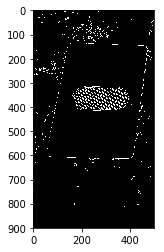

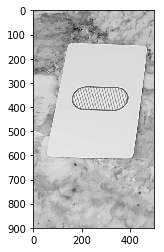

In [23]:
def get_thresholds(image):
    # https://en.wikipedia.org/wiki/Otsu%27s_method
    hi, _ = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    lo = .5 * hi
    return lo, hi

img = card1_

lo, hi = get_thresholds(img)

hi = 200  # actually, tune by hand
canny = cv2.Canny(img, .5 * hi, hi)

plt.imshow(canny, cmap="gray")
plt.show()
plt.imshow(img, cmap="gray")
plt.show()

In [24]:
def get_diophantine(rho, theta):
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    # ax + by + c = 0
    c = -a * x0 - b * y0
    return a, b, c


def get_segment(rho, theta):
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))
    return Point2(x=x1, y=y1), Point2(x=x2, y=y2)

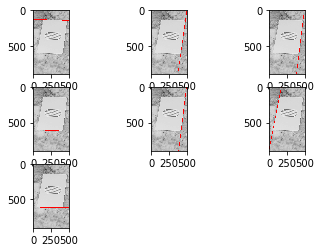

In [33]:
img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)


def add_lines(lines, image, *line_args):
    img_ = image.copy()
    for line, in lines:
        rho, theta = line
        p1, p2 = get_segment(rho, theta)
        img_ = cv2.line(img_, p1, p2, *line_args)
    return img_


# This Hough threshold yields a reasonable number of lines that contain the desired ones.
hough_t = 150

lines = cv2.HoughLines(canny, 1, np.pi / 180, hough_t)


def show_lines(lines):
    n = len(lines)
    import math
    s = int(math.ceil(math.sqrt(n)))

    plt.figure()
    for k, line in enumerate(lines):
        img_with_line = add_lines([line], img_color, (255, 0, 0), 5)
        plt.subplot(s, s, k + 1)
        plt.imshow(img_with_line)
        
    plt.show()
    
    
if True:
    # We can plot the lines to find the index of the one we want.
    show_lines(lines)

In [20]:
# Another cool line detector.. median blur?
# https://stackoverflow.com/questions/46565975/find-intersection-point-of-two-lines-drawn-using-houghlines-opencv/46572063
if False:
    import cv2
    import numpy as np

    img = cv2.imread('sudoku.jpg')
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.medianBlur(gray, 5)
    adapt_type = cv2.ADAPTIVE_THRESH_GAUSSIAN_C
    thresh_type = cv2.THRESH_BINARY_INV
    bin_img = cv2.adaptiveThreshold(blur, 255, adapt_type, thresh_type, 11, 2)

In [36]:
def intersection(line1, line2):
    """Finds the intersection of two lines given in Hesse normal form.

    Returns closest integer pixel locations.
    See https://stackoverflow.com/a/383527/5087436
    """
    rho1, theta1 = line1[0]
    rho2, theta2 = line2[0]
    A = np.array([
        [np.cos(theta1), np.sin(theta1)],
        [np.cos(theta2), np.sin(theta2)]
    ])
    b = np.array([[rho1], [rho2]])
    
    try:
        x0, y0 = np.linalg.solve(A, b)
    except np.linalg.LinAlgError:  # although, it didn't seem to work...
        return None
    
    x0, y0 = int(np.round(x0)), int(np.round(y0))
    return [[x0, y0]]

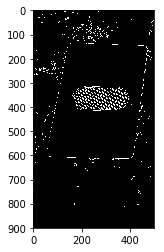

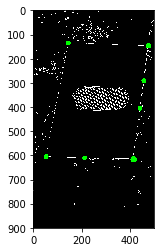

[[[478, 147]],
 [[474, 147]],
 [[476, 147]],
 [[145, 135]],
 [[27254, 1082]],
 [[442, 405]],
 [[412, 617]],
 [[458, 291]],
 [[1354, -6087]],
 [[413, 613]],
 [[416, 617]],
 [[1041, -4477]],
 [[416, 613]],
 [[418, 617]],
 [[54, 604]],
 [[213, 610]],
 [[1047, -4505]],
 [[418, 613]],
 [[53, 607]]]

In [37]:
import itertools

canny_ = cv2.cvtColor(canny, cv2.COLOR_GRAY2RGB)

pointed = canny_.copy()
show_image(pointed)
points = [intersection(l1, l2) for l1, l2 in itertools.combinations(lines, 2)]
points = [p for p in points if p is not None]

if True:
    for point, in points:
        cv2.circle(pointed, tuple(point), 10, (0,255,0), -1)

    # rect = cv2.minAreaRect(card_contour)  # perspective transform is better.
    show_image(pointed)

points
# Already a problem... but we can do some box detection...?

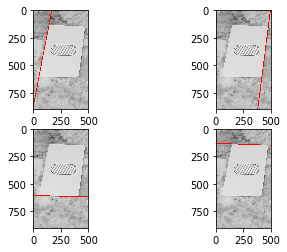

In [38]:
# lines[:,0,:].shape

from sklearn.cluster import KMeans

kmeans = KMeans(4)

kmeans.fit(lines[:,0,:])

kmeans.cluster_centers_

lines_ = kmeans.cluster_centers_.reshape((-1, 1, 2))
lines_

show_lines(lines_)

In [40]:
def some_cross(a, b, c):
    return (b.x - a.x) * (c.y - a.y) - (c.x - a.x) * (b.y - a.y)


def check_points(p1, p2, p3, p4):
        points = [p1, p2, p3, p4]
        turn_seq = [None] * 6
        turn_seq[1:-1] = points
        turn_seq[0] = points[-1]
        turn_seq[-1] = points[0]
        turns = zip(turn_seq[:-2], turn_seq[1:-1], turn_seq[2:])
        return all(some_cross(*turn) > 0 for turn in turns)


def find_box(l1, l2, l3, l4):
    for perm in itertools.permutations([l1, l2, l3, l4]):
        """4! = 24 iterations."""
        cycle = list(perm) + [perm[0]]
        points = [intersection(*pair) for pair in zip(cycle[:-1], cycle[1:])]
        
        if any(p is None for p in points):
            return

        def _(point):
            p, = point
            x, y = p
            return Point2(x=x, y=y)

        points_ = [_(p) for p in points]
        # assert False, points_
        if check_points(*points_):
            return points


def find_boxes(lines):
    """Find any boxes enclosed by a set of lines."""
    for lines_ in itertools.combinations(lines, 4):
        box = find_box(*lines_)
        if box is not None:
            yield np.array(box)


def eliminate_duplicate_polys(polys, iou_threshold=.95):
    boxes_ = []
    for box in boxes:
        if all(
            geom.area_intersection_over_union(box, box_) < iou_threshold
            for box_ in boxes_
        ):
            boxes_.append(box)
            yield np.array(box)

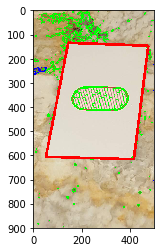

In [42]:
import geom

# boxes = list(eliminate_duplicates(find_boxes(lines)))
boxes = list(find_boxes(lines_))
polys = [box.reshape((4, 2)) for box in boxes]


if False:
    for box in boxes:
        warped = four_point_transform(card1, box.reshape(4, 2))
        show_image(warped)

if True:
    As = [geom.area(poly) for poly in polys]

# Will need, somehow, to throw away slivers...
# geom.area(polys[0])
As

for poly in polys:
    # cv2.polylines(my_img,[pts],True,(0,255,255)
    color = (255, 0, 0)
    boxed = card1.copy()
    cv2.polylines(boxed, [poly], True, color, 10)
    show_image(boxed)

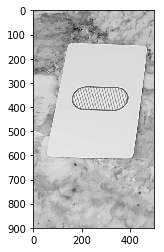

error: /opencv-3.3.0/modules/imgproc/src/color.cpp:10638: error: (-215) scn == 3 || scn == 4 in function cvtColor


In [25]:
def find_lines():
    pass

show_image(img)

gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
show_image(gray)

resized, edged, ratio = find_edges_gray(gray)

# This Hough threshold yields a reasonable number of lines that contain the desired ones.
hough_t = 50
lines = cv2.HoughLines(edged, 1, np.pi / 180, hough_t)

boxes = find_boxes(lines)


#for point, in points:
#    cv2.circle(pointed, tuple(point), 10, (0,255,0), -1)
lines, len(lines)

list(boxes)

In [33]:
p1, p2 = polys[:2]
p1, p2
geom.area_intersection_over_union(p1, p2)
# geom.poly_intersection(p1, p2)
# geom.vertices_to_hull_inequality(p1)
# geom.vertices_to_hull_inequality([(0,0), (100, 0), (50,100)])
# p1

for (i, p1), (j, p2) in itertools.combinations(enumerate(polys), 2):
    print(i, j, geom.area_intersection_over_union(p1, p2))

0 1 0.0
0 2 9.46678939339e-08
0 3 0.0474964455676
0 4 0.0
0 5 9.46760285732e-08
0 6 0.0
0 7 0.0
0 8 2.38280860026e-08
0 9 0.0
0 10 0.0
0 11 0.0
0 12 0.00198986074734
0 13 0.0
0 14 0.0843715110232
0 15 0.00198953324554
0 16 0.0
0 17 0.00202548048568
1 2 0.0
1 3 0.0
1 4 2.11638214434
1 5 3.04811575696e-07
1 6 1.26180759525e-05
1 7 0.0
1 8 9.56356405177e-05
1 9 0.0
1 10 0.0
1 11 0.0
1 12 4.07921997548e-07
1 13 6.47380593818e-09
1 14 1.44037360174e-05
1 15 1.30030895387e-06
1 16 0.0
1 17 6.50103321607e-05
2 3 2.36140459139e-08
2 4 0.0
2 5 -9.29742380198
2 6 -8.3184479053
2 7 -8.49459230764
2 8 -8.34722725486
2 9 0.084772658054
2 10 0.0
2 11 0.0845170677356
2 12 0.0854793933468
2 13 0.0
2 14 0.299481622926
2 15 0.0852283578233
2 16 0.398257667879
2 17 0.120901188268
3 4 0.0
3 5 2.36160704964e-08
3 6 0.0
3 7 0.0
3 8 0.0
3 9 0.0
3 10 0.0
3 11 0.0
3 12 0.0
3 13 0.0
3 14 0.0806578362516
3 15 0.0
3 16 0.0
3 17 0.0
4 5 0.0
4 6 0.0
4 7 0.0
4 8 3.23931160817e-06
4 9 0.0
4 10 0.0
4 11 0.0
4 12 0.0
4

In [ ]:
box1, box2 = boxes[:2]

geom.area_intersection_over_union(box1, box2)

In [ ]:
list(boxes)